In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from numpy import genfromtxt
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
import csv


In [2]:
from corrome.sim import chain_interactions
from skbio.stats.composition import closure
from corrome.sim import compositional_noise
from numpy.random import RandomState
from skbio.stats.composition import perturb
from scipy.stats import expon
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from corrome.sim import multinomial_sample
from sklearn.ensemble import RandomForestRegressor


In [3]:
n=100

x1=np.empty([n,1])
x2=np.empty([n,1])
x3=np.empty([n,1])
x4=np.empty([n,1])


In [4]:
for i in range(0,n):
    x1[i]=np.random.randint(2, size=1)
    x2[i]=i+1
    

x3=np.log(x2)
x4=x3*x2
x1
table=np.concatenate((x1,x2,x3,x4),axis=1)


In [5]:
np.random.seed()
clsens=np.zeros(50)
clspec=np.zeros(50)
rfsens=np.zeros(50)
rfspec=np.zeros(50)
betaval=np.zeros(50)

In [6]:
for k in range(0,10):    
    gt=np.empty([n,4])
    for j in range(0,4): 
        coef=np.random.normal(0, 5, 4)
        for i in range(0,n):    
            coef=np.absolute(coef)
            gt[i,j]=coef[0]*x1[i]+coef[1]*x2[i]+coef[2]*x3[i]+coef[3]*x4[i]
    betaval[k]=np.linalg.norm(gt)

    microbial_truth=gt
    microbial_table = closure(microbial_truth)
    gradient = np.linspace(0, 36, 100)
    rng = RandomState(0)
    cov = np.eye(3)
    m_noise = compositional_noise(cov, nsamp=len(gradient), rng=rng)
    microbial_table = np.vstack([
        perturb(microbial_table[i, :], m_noise[i, :])
        for i in range(len(gradient))])
    x = np.linspace(0, 11, 100)
    contaminant_urn = closure(expon.pdf(x))
    plt.plot(contaminant_urn)
    plt.xlabel('Species')
    plt.ylabel('Proportion')
    contaminant_urns = np.repeat(np.expand_dims(contaminant_urn, axis=0),
                             microbial_table.shape[0], axis=0)
    microbial_table = np.hstack((microbial_table, contaminant_urns))
    microbial_table = closure(microbial_table)
    microbial_table = multinomial_sample(microbial_table, lam=10000)
    
    cl = linear_model.MultiTaskLassoCV()
    cl.fit(X=microbial_table,y=table)
    clcoef=np.ones(104)
    for i in range(0,104):
        if all(v == 0 for v in cl.coef_[:,i]):
            clcoef[i]=0
    clsens[k]=sum(clcoef[0:4])/4;
    clspec[k]=(100-sum(clcoef[4:100]))/100;
    rf=RandomForestRegressor()
    rf.fit(X=microbial_table,y=table)
    rfcoef=np.ones(104)
    for i in range(0,104):
        if rf.feature_importances_[i]==0:
            rfcoef[i]=0
    
    rfsens[k]=sum(rfcoef[0:4])/4;
    rfspec[k]=(100-sum(rfcoef[4:100]))/100;


/Users/joyce/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/joyce/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/joyce/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/joyce/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

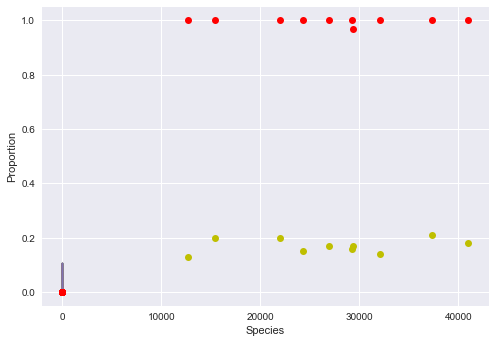

In [8]:
plt.plot(betaval, rfspec, 'yo')
plt.plot(betaval, clspec, 'ro')
plt.show()

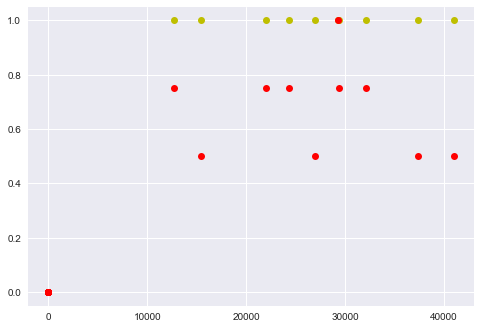

In [9]:
plt.plot(betaval, rfsens, 'yo')
plt.plot(betaval, clsens, 'ro')
plt.show()

In [103]:
with open('microbial_table.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    [writer.writerow(r) for r in microbial_table]